## Moku Example: Automating FIR Filter for Dual Frequency Resonance Tracking

The purpose of this example is to exhibit the accuracy of the dual frequency resonance tracker (DFRT) by automatically changing the center frequency of the FIR filter box. The FIR filter box is used in a bandpass configuration with a sharp peak to simulate a resonator. Normally, DFRT would track the resonant peak of a resonator. In this case it is tracking the center frequency of an FIR filter. For an explanation of DFRT and how to build it on the Moku, please visit the application notes section on our website.

**(c) 2025 Liquid Instruments Pty. Ltd.**

In [11]:
from moku.instruments import FIRFilterBox, MultiInstrument, LockInAmp, PIDController, WaveformGenerator
import time
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

The FIR filter is running on one Moku and the DFRT system is running on another Moku. This first block of code connects to each Moku device, and configures all of the instruments. For Multi-instrument mode, each instrument must be set into their respective slots, and then configured accordingly. For the Moku that is running the DFRT, two waveforms are generated, externally combined using an RF splitter, and sent to input 1 of the Moku running the FIR filter. Each generated waveform is also sent to input B of each Lock In amplifier as a demodulation source. The output of the FIR filter, which is the response of the 'resonator', is sent to the input of the two Lock In amplifiers to determine the amplitude of each frequency component in the combined signal. The outputs of the Lock In amplifiers go to the PID controller, and the PID output control signal goes to both waveform generators as a modulation signal.

In [ ]:
f=FIRFilterBox('192.168.##.##', force_connect=True)
m=MultiInstrument('192.168.##.##', force_connect=True, platform_id=4)

try:
    f.set_frontend(channel=1, impedance='50Ohm', coupling='DC', attenuation='0dB')
    f.enable_output(channel=1, signal=True, output=True)
    f.set_control_matrix(channel=1, input_gain1=1, input_gain2=0)
    f.set_input_gain(channel=1, gain=0)
    f.set_input_offset(channel=1, offset=0)
    f.set_output_gain(channel=1, gain=0)
    f.set_output_offset(channel=1, offset=0)
    f.set_monitor(monitor_channel=1, source='Output1')
    f.set_by_frequency(channel=1, sample_rate='39.06MHz', coefficient_count=61, shape='Bandpass',
                        low_corner=0.2432, high_corner=0.2944)

    lia1=m.set_instrument(slot=1, instrument=LockInAmp)
    lia2=m.set_instrument(slot=2, instrument=LockInAmp)
    pid=m.set_instrument(slot=3, instrument=PIDController)
    wg=m.set_instrument(slot=4, instrument=WaveformGenerator)

    connections=[dict(source='Slot1OutA', destination='Slot3InB'),
                 dict(source='Slot2OutA', destination='Slot3InA'),
                 dict(source='Slot3OutA', destination='Slot4InA'),
                 dict(source='Slot3OutA', destination='Slot4InB'),
                 dict(source='Slot4OutA', destination='Output1'),
                 dict(source='Slot4OutA', destination='Slot2InB'),
                 dict(source='Slot4OutB', destination='Output2'),
                 dict(source='Slot4OutB', destination='Slot1InB'),
                 dict(source='Input1', destination='Slot1InA'),
                 dict(source='Input1', destination='Slot2InA')]
    m.set_connections(connections=connections)

    m.set_frontend(channel=1, impedance='50Ohm', coupling='DC', attenuation='0dB')
    m.set_output(channel=1,output_gain='0dB')
    m.set_output(channel=2, output_gain='0dB')

    lia1.set_demodulation(mode='ExternalPLL')
    lia1.set_filter(corner_frequency=100, slope='Slope18dB')
    lia1.set_outputs(main='R', aux='None', main_offset=0, aux_offset=0)
    lia1.set_pll(auto_acquire=False, frequency=11e6, bandwidth='100kHz')
    lia1.set_polar_mode(range='2Vpp')

    lia2.set_demodulation(mode='ExternalPLL')
    lia2.set_filter(corner_frequency=100, slope='Slope18dB')
    lia2.set_outputs(main='R', aux='None', main_offset=0, aux_offset=0)
    lia2.set_pll(auto_acquire=False, frequency=10e6, bandwidth='100kHz')
    lia2.set_polar_mode(range='2Vpp')

    pid.enable_input(channel=1, enable=True)
    pid.enable_output(channel=1, signal=True, output=True)
    pid.set_by_frequency(channel=1, prop_gain= -32.5, int_crossover=313)
    pid.set_control_matrix(channel=1, input_gain1=-1, input_gain2=1)
    pid.set_control_matrix(channel=2, input_gain1=1,input_gain2=1)
    pid.set_monitor(monitor_channel=1, source='Output1')

    wg.generate_waveform(channel=1, type='Sine', amplitude=0.1, frequency=10e6)
    wg.generate_waveform(channel=2, type='Sine', amplitude=0.1, frequency=11e6)
    wg.set_modulation(channel=1, type='Frequency', source='InputA', depth=1e6)
    wg.set_modulation(channel=2, type='Frequency', source='InputA', depth=1e6)
    wg.sync_phase()

    m.sync()


except Exception as e:
    print(f'Exception occurred: {e}')

finally:
    print('Successfully configured instruments.')



Successfully configured instruments.


This is the automation of the FIR filter. Each `set_by_frequency` call changes the center frequency of the FIR filter, thus simulating a resonator with its variable resonant frequency. The block of code also downloads the data log from the Moku to your local directory.

In [ ]:
try:
    log=pid.start_logging()
    file_name=log['file_name']

    f.set_by_frequency(channel=1, sample_rate='39.06MHz', coefficient_count=61, shape='Bandpass',
                        low_corner=0.2432, high_corner=0.2944)
    print('Set center frequency to 10.5MHz')

    time.sleep(12)

    f.set_by_frequency(channel=1, sample_rate='39.06MHz', coefficient_count=61, shape='Bandpass',
                        low_corner=0.2496, high_corner=0.3008)
    print('Set center frequency to 10.75MHz')

    time.sleep(12)

    f.set_by_frequency(channel=1, sample_rate='39.06MHz', coefficient_count=61, shape='Bandpass',
                        low_corner=0.256, high_corner=0.3072)
    print('Set center frequency to 11MHz')

    time.sleep(12)

    f.set_by_frequency(channel=1, sample_rate='39.06MHz', coefficient_count=61, shape='Bandpass',
                        low_corner=0.2624, high_corner=0.3136)
    print('Set center frequency to 11.25MHz')

    time.sleep(12)

    f.set_by_frequency(channel=1, sample_rate='39.06MHz', coefficient_count=61, shape='Bandpass',
                        low_corner=0.2432, high_corner=0.2944)
    print('Reset center frequency back to 10.5MHz')

    time.sleep(5)

    pid.stop_logging()
    FILE_PATH='C:/Users/Path/Downloads' #Change to /user/your_path/to_downloads
    temp_file= FILE_PATH + '/dfrt_pid_output' + time.strftime('%d-%m-%Y-%H_%M_%S_') 
    pid.download('ssd', file_name, temp_file + '.li')
    os.system(f'mokucli convert {temp_file}'+'.li')
    print('Successfully downloaded logs as .csv.')
    

except Exception as e:
    print(f'Exception occurred: {e}')
finally:
    print('Successfully changed center frequency.')



Set center frequency to 10.5MHz
Set center frequency to 10.75MHz
Set center frequency to 11MHz
Set center frequency to 11.25MHz
Reset center frequency back to 10.5MHz
Successfully downloaded logs as .csv.
Successfully changed center frequency.


This block of code imports the downloaded file for data processing. 

In [23]:
data=pd.read_csv(temp_file +'.csv', comment='%', header=None)
print('Successfully read .csv logs.')
print(data)


Successfully read .csv logs.
            0         1
0       0.000 -0.014169
1       0.001 -0.014169
2       0.002 -0.014169
3       0.003 -0.014169
4       0.004 -0.014169
...       ...       ...
56915  56.915  0.149240
56916  56.916  0.149173
56917  56.917  0.149039
56918  56.918  0.149106
56919  56.919  0.149106

[56920 rows x 2 columns]


Separate the data into time components and voltage components.

In [ ]:
time=data.iloc[:, 0]
voltage=data.iloc[:, 1]

This block creates a plot of the PID controller output, showing how it responds to the center frequency based on the FM depth of the waveform generators.

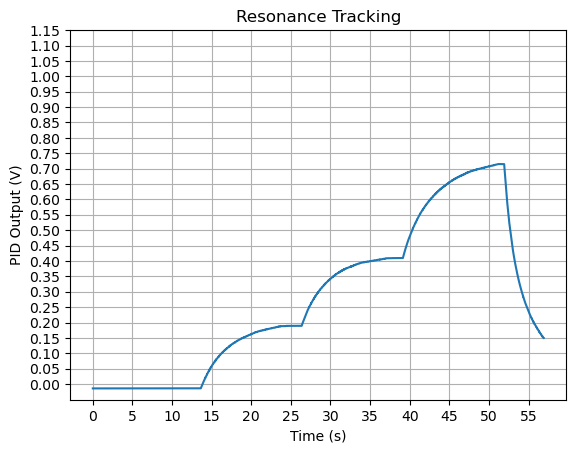

In [ ]:
plt.plot(time,voltage)
plt.xlabel('Time (s)')
plt.ylabel('PID Output (V)')
plt.title('Resonance Tracking')
plt.yticks(np.arange(0,1.2,0.05))
plt.xticks(np.arange(0,60, 5))
plt.grid(True)
plt.show()

The following two blocks relinquish resources.

In [26]:
try:
    f.relinquish_ownership()
except Exception as e:
    print(f'Exception occurred: {e}')
finally:
    print('Relinquished ownership.')

Relinquished ownership.


In [28]:
try:
    m.relinquish_ownership()
except Exception as e:
    print(f'Exception occurred: {e}')
finally:
    print('Relinquished ownership.')

Relinquished ownership.


On the PID output plot, the voltage value will eventually settle to a constant value and this value determines the change in center frequency. We want to use these values because this is the point where the DFRT system has successfully tracked and locked onto the center frequency.

In [29]:
voltage1=data.iloc[:,1][data.iloc[:,0]==12].iloc[0]
voltage2=data.iloc[:,1][data.iloc[:,0]==25].iloc[0]
voltage3=data.iloc[:,1][data.iloc[:,0]==38].iloc[0]
voltage4=data.iloc[:,1][data.iloc[:,0]==50].iloc[0]


The following block of code takes the data that was logged, and calculates the center frequency. Then, the calculated frequency is compared to the actual center frequency and the precent error is calculated.

In [30]:
## Resonance Calculation ##
print('Resonant Frequency: 10.5MHz')
res1=10.5 + voltage1
print(f'Calculated Resonance: {round(res1,2)}MHz')
error1=abs((res1-10.5)/10.5)*100
print(f'Percent Error: {round(error1,2)}%\n')

print('Resonance changed to: 10.75MHz')
res2=10.5 + voltage2
print(f'Calculated resonance: {round(res2,2)}MHz')
error2=abs((res2-10.75)/10.75)*100
print(f'Percent Error: {round(error2,2)}%\n')

print('Resonance changed to: 11MHz')
res3=10.5 + voltage3
print(f'Calculated resonance: {round(res3,2)}MHz')
error3=abs((res3-11)/11)*100
print(f'Percent Error: {round(error3, 2)}%\n')

print('Resonance changed to: 11.25MHz')
res4=10.5 + voltage4
print(f'Calculated resonance: {round(res4,2)}MHz')
error4=abs((res4-11.25)/11.25)*100
print(f'Percent Error: {round(error4, 2)}%\n')






Resonant Frequency: 10.5MHz
Calculated Resonance: 10.49MHz
Percent Error: 0.13%

Resonance changed to: 10.75MHz
Calculated resonance: 10.69MHz
Percent Error: 0.57%

Resonance changed to: 11MHz
Calculated resonance: 10.91MHz
Percent Error: 0.83%

Resonance changed to: 11.25MHz
Calculated resonance: 11.21MHz
Percent Error: 0.38%



The plots below are the frequency response curves, or Bode plots, of the FIR filter. The true center frequency of the FIR filters are shown on the plots. The percent error is coming from the DFRT not exactly tracking the center frequency due to the imperfect symmetry of the FIR filter. 

![title](FRA_FIR_10.5.png)

![title](fra_fir_10.75.png)

![title](fra_fir_11.png)

![title](fra_fir_11.25.png)